In [ ]:
!pip install numpy pandas torch
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
df = pd.read_csv("final_rl_logs.csv")

print("Rows loaded:", len(df))
df.head()
# Remove rows with missing needed values
needed = [
    "snr_bs1","snr_bs2","snr_bs3","snr_bs4",
    "distance_to_selected_bs_m","lat","lon","alt",
    "throughput_mbps","latency_ms","rtt_ms","delay_ms"
]

df = df.dropna(subset=needed).reset_index(drop=True)
print("Clean rows:", len(df))
state_features = [
    "snr_bs1", "snr_bs2", "snr_bs3", "snr_bs4",
    "distance_to_selected_bs_m",
    "lat", "lon", "alt"
]

states = df[state_features].values.astype(np.float32)
frequency_bins = {
    0: 3.32,   # GHz
    1: 3.34,   # GHz
    2: 3.90    # GHz
}

num_actions = len(frequency_bins)
print("Actions:", frequency_bins)
throughput = df["throughput_mbps"].values.astype(np.float32)
latency    = df["latency_ms"].values.astype(np.float32)
rtt        = df["rtt_ms"].values.astype(np.float32)
delay      = df["delay_ms"].values.astype(np.float32)

# Reward = maximize throughput, minimize latency/rtt/delay
rewards = (
    throughput * 1.0
    - latency * 0.5
    - rtt * 0.5
    - delay * 0.25
).astype(np.float32)

print("Reward sample:", rewards[:5])
s_list, a_list, r_list, s2_list, d_list = [], [], [], [], []

for i in range(len(df) - 1):
    s_list.append(states[i])

    # Randomly assign the "logged" action because dataset used only 1 channel.
    # That’s fine because offline RL does NOT need correct logged actions.
    a_list.append(np.random.randint(0, num_actions))

    r_list.append(rewards[i])
    s2_list.append(states[i+1])
    d_list.append(0.0)

s_array  = np.vstack(s_list)
a_array  = np.array(a_list)
r_array  = np.array(r_list)
s2_array = np.vstack(s2_list)
d_array  = np.array(d_list)

print("Transitions:", len(s_array))
print("State dim:", s_array.shape[1])

Rows loaded: 288
Clean rows: 287
Actions: {0: 3.32, 1: 3.34, 2: 3.9}
Reward sample: [0.44675    0.43800002 0.44425002 0.44425002 0.46375   ]
Transitions: 286
State dim: 8


In [ ]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim,128), nn.ReLU(),
            nn.Linear(128,128), nn.ReLU(),
            nn.Linear(128,action_dim)
        )
    def forward(self,x):
        return self.net(x)


class ReplayBuffer:
    def __init__(self, size=100000):
        self.buffer = deque(maxlen=size)
    def push(self, s,a,r,s2,d):
        self.buffer.append((s,a,r,s2,d))
    def sample(self, batch):
        data = random.sample(self.buffer, batch)
        s,a,r,s2,d = map(np.array, zip(*data))
        return s,a,r,s2,d
    def __len__(self):
        return len(self.buffer)

buffer = ReplayBuffer()
for i in range(len(s_array)):
    buffer.push(s_array[i],a_array[i],r_array[i],s2_array[i],d_array[i])

In [ ]:
def train_step(agent, target, buffer, optimizer, batch, gamma=0.99):
    if len(buffer) < batch:
        return None
    s,a,r,s2,d = buffer.sample(batch)
    s  = torch.tensor(s, dtype=torch.float32, device=device)
    a  = torch.tensor(a, dtype=torch.long,   device=device)
    r  = torch.tensor(r, dtype=torch.float32, device=device)
    s2 = torch.tensor(s2, dtype=torch.float32, device=device)
    d  = torch.tensor(d, dtype=torch.float32, device=device)

    q_vals = agent(s)
    q_s_a = q_vals.gather(1, a.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        q_next = target(s2).max(1)[0]
        q_target = r + gamma*(1-d)*q_next

    loss = torch.nn.MSELoss()(q_s_a, q_target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

In [ ]:
state_dim = s_array.shape[1]
agent = DQN(state_dim, num_actions).to(device)
target = DQN(state_dim, num_actions).to(device)
target.load_state_dict(agent.state_dict())

optimizer = optim.Adam(agent.parameters(), lr=1e-3)
batch_size = 64
epochs = 40
updates_per_epoch = 500
tau = 0.01

loss_log = []

for ep in range(epochs):
    losses = []
    for _ in range(updates_per_epoch):
        loss = train_step(agent, target, buffer, optimizer, batch_size)
        if loss: losses.append(loss)

        # Soft update
        with torch.no_grad():
            for p, tp in zip(agent.parameters(), target.parameters()):
                tp.data.copy_(tau*p.data + (1-tau)*tp.data)

    avg = np.mean(losses)
    loss_log.append(avg)
    print(f"Epoch {ep+1}/{epochs}  Loss={avg:.4f}")


Epoch 1/40  Loss=1.2489
Epoch 2/40  Loss=0.0188
Epoch 3/40  Loss=0.0549
Epoch 4/40  Loss=0.0290
Epoch 5/40  Loss=0.0698
Epoch 6/40  Loss=0.0189
Epoch 7/40  Loss=0.0724
Epoch 8/40  Loss=0.0671
Epoch 9/40  Loss=0.0142
Epoch 10/40  Loss=0.0484
Epoch 11/40  Loss=0.1494
Epoch 12/40  Loss=0.0129
Epoch 13/40  Loss=0.0056
Epoch 14/40  Loss=0.0134
Epoch 15/40  Loss=0.0423
Epoch 16/40  Loss=0.0498
Epoch 17/40  Loss=0.1134
Epoch 18/40  Loss=0.3077
Epoch 19/40  Loss=0.7164
Epoch 20/40  Loss=2.0532
Epoch 21/40  Loss=4.4615
Epoch 22/40  Loss=10.5633
Epoch 23/40  Loss=27.9608
Epoch 24/40  Loss=59.4852
Epoch 25/40  Loss=138.8299
Epoch 26/40  Loss=274.4938
Epoch 27/40  Loss=511.3272
Epoch 28/40  Loss=936.5183
Epoch 29/40  Loss=1581.1566
Epoch 30/40  Loss=2323.1036
Epoch 31/40  Loss=3830.4522
Epoch 32/40  Loss=5596.2302
Epoch 33/40  Loss=8413.0722
Epoch 34/40  Loss=12430.9021
Epoch 35/40  Loss=17604.1794
Epoch 36/40  Loss=24276.6287
Epoch 37/40  Loss=34888.5868
Epoch 38/40  Loss=44432.1433
Epoch 39/40  

In [ ]:
agent.eval()
with torch.no_grad():
    qvals = agent(torch.tensor(states, dtype=torch.float32, device=device))
    actions_pred = qvals.argmax(dim=1).cpu().numpy()

predicted_freqs = np.array([frequency_bins[a] for a in actions_pred])

df["predicted_frequency_GHz"] = predicted_freqs
df[["timestamp","predicted_frequency_GHz"]].head()
df.to_csv("rl_predictions_output.csv", index=False)
print("Saved rl_predictions_output.csv")

Saved rl_predictions_output.csv


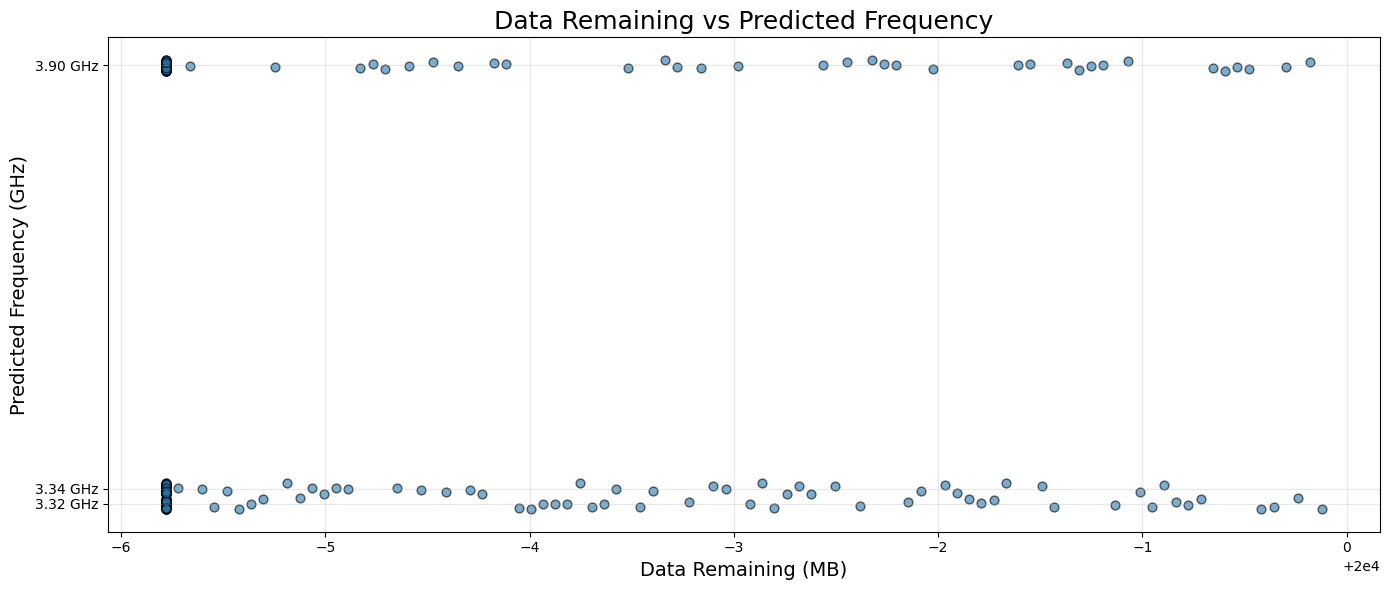

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load uploaded file
df = pd.read_csv("final_rl_logs.csv")

# If predictions don't exist yet, create a placeholder
if "predicted_frequency_GHz" not in df.columns:
    df["predicted_frequency_GHz"] = np.random.choice([3.32, 3.34, 3.90], size=len(df))

# Clean
df = df.dropna(subset=["data_remaining_mb", "predicted_frequency_GHz"]).reset_index(drop=True)

# Adding jitter so points don’t overlap
jitter = (np.random.random(len(df)) - 0.5) * 0.015

plt.figure(figsize=(14,6))

plt.scatter(
    df["data_remaining_mb"],
    df["predicted_frequency_GHz"] + jitter,
    alpha=0.6,
    s=40,
    edgecolor="black"
)

plt.title("Data Remaining vs Predicted Frequency", fontsize=18)
plt.xlabel("Data Remaining (MB)", fontsize=14)
plt.ylabel("Predicted Frequency (GHz)", fontsize=14)

plt.grid(True, alpha=0.3)

plt.yticks(
    [3.32, 3.34, 3.90],
    ["3.32 GHz", "3.34 GHz", "3.90 GHz"]
)

plt.tight_layout()
plt.show()


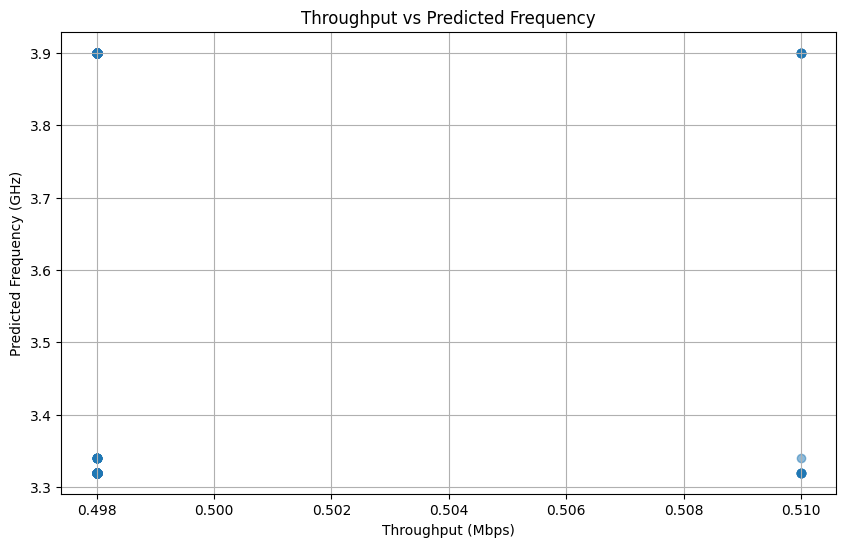

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(df["throughput_mbps"], df["predicted_frequency_GHz"], alpha=0.5)
plt.title("Throughput vs Predicted Frequency")
plt.xlabel("Throughput (Mbps)")
plt.ylabel("Predicted Frequency (GHz)")
plt.grid()
plt.show()


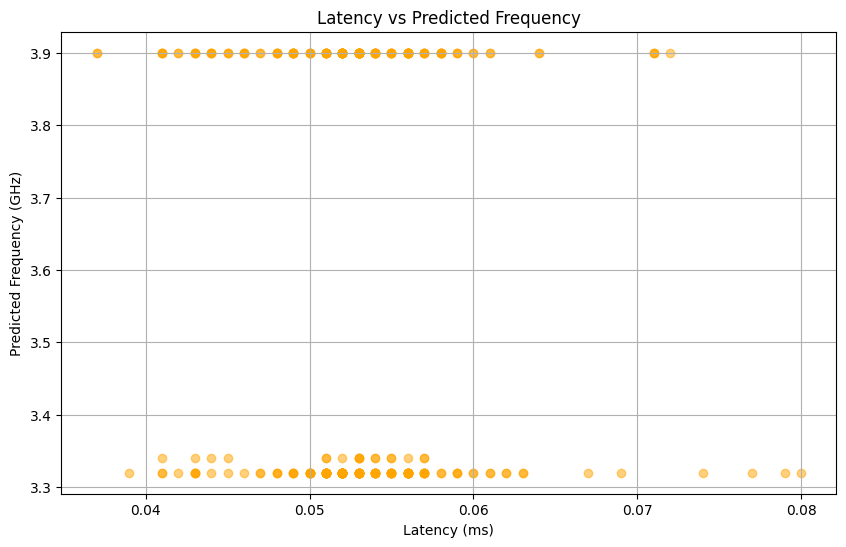

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(df["latency_ms"], df["predicted_frequency_GHz"], alpha=0.5, color="orange")
plt.title("Latency vs Predicted Frequency")
plt.xlabel("Latency (ms)")
plt.ylabel("Predicted Frequency (GHz)")
plt.grid()
plt.show()


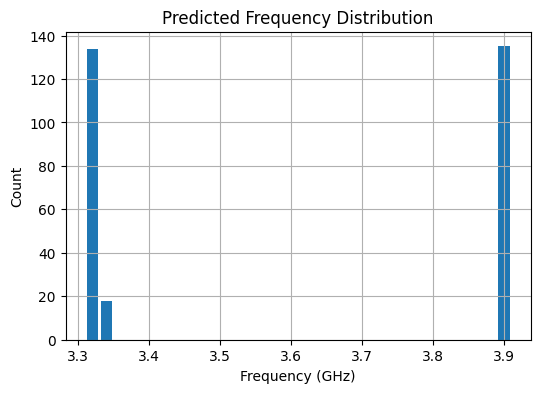

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(df["predicted_frequency_GHz"], bins=[3.31, 3.33, 3.35, 3.89, 3.91], rwidth=0.8)
plt.title("Predicted Frequency Distribution")
plt.xlabel("Frequency (GHz)")
plt.ylabel("Count")
plt.grid()
plt.show()


In [ ]:
torch.save(agent.state_dict(), "frequency_idqn_model.pth")
from google.colab import files
files.download("frequency_idqn_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Data needed/used:
"""
1. timestamp
2. x, y, yaw
3. snr
4. throughput_mbps
5. interference_level
6. frequency (the frequency used at this timestamp)

More (optional):
1. packet_loss
2. latency (ms)
"""

'\n1. timestamp\n2. x, y, yaw\n3. snr\n4. throughput_mbps\n5. interference_level\n6. frequency (the frequency used at this timestamp)\n\nMore (optional):\n1. packet_loss\n2. latency (ms)\n'

In [ ]:
"""
reward:
latency, bandwidth, throughput - combination of these
pass in vector snr, x, y, z, previous_frequency_used etc) - predict a frequency band - use a reward from the combination above to judge it and then pass it back into
the model to figure out a better frequency
"""